The purpose of this notebook is to identify ancestry-associated genes

In [1]:
#Load packages
library(tidyverse)
library(reshape2)
library(ggrepel)

#Load functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
#Load in the rfmix data
setwd('/home/jupyter/Ancestry/rfmix')
rfmix.file.list = list.files(path = ".", pattern = ".Q")
rfmix.file.list

#Compile it all into a single object
rfmix.data = NULL #create an empty object to hold the data
index = 0 #define the for loop index
for(file in rfmix.file.list){
    index = index + 1 #increase the index
    
    
    #Load in and format the data
    individual.chromosome = read.table(file, fill = TRUE) %>%
    rename("sample" = 1, "AFR" = 2, "AMR" = 3, "EAS" = 4, "EUR" = 5, "SAS" = 6) %>%
    select(-sample)
    
    
    
    #Add the data to the main data frame
    if(index == 1) {
        rfmix.data = individual.chromosome
    } else {
        rfmix.data = rfmix.data + individual.chromosome
    }
    
    
    
    #Divide the data by the number of chromosomes to get the ancestry fraction across the genome
    if(index == length(rfmix.file.list)) {
        rfmix.data = rfmix.data/length(rfmix.file.list)
    }
    
    
    
    #Re-add the sample names
    if(index == length(rfmix.file.list)){
        sample.names = read.table(file, fill = TRUE) %>%
        rename("sample" = 1) %>%
        pull(sample) 
        
    rfmix.data = rfmix.data %>%
        mutate(sample = sample.names, .before = "AFR")
    }
    
}

head(rfmix.data)
write.table(rfmix.data, "collapsed.ancestry.information.txt", sep = "\t", col.names = TRUE)

[1] "chr1.rfmix.output.rfmix.Q"  "chr10.rfmix.output.rfmix.Q"
 [3] "chr11.rfmix.output.rfmix.Q" "chr12.rfmix.output.rfmix.Q"
 [5] "chr13.rfmix.output.rfmix.Q" "chr14.rfmix.output.rfmix.Q"
 [7] "chr15.rfmix.output.rfmix.Q" "chr16.rfmix.output.rfmix.Q"
 [9] "chr17.rfmix.output.rfmix.Q" "chr18.rfmix.output.rfmix.Q"
[11] "chr19.rfmix.output.rfmix.Q" "chr2.rfmix.output.rfmix.Q" 
[13] "chr20.rfmix.output.rfmix.Q" "chr21.rfmix.output.rfmix.Q"
[15] "chr22.rfmix.output.rfmix.Q" "chr3.rfmix.output.rfmix.Q" 
[17] "chr4.rfmix.output.rfmix.Q"  "chr5.rfmix.output.rfmix.Q" 
[19] "chr6.rfmix.output.rfmix.Q"  "chr7.rfmix.output.rfmix.Q" 
[21] "chr8.rfmix.output.rfmix.Q"  "chr9.rfmix.output.rfmix.Q"

,sample,AFR,AMR,EAS,EUR,SAS
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000657,0.9601677273,0.0005504545,0.0063213636,0.03192409,0.0010363636
2,ACH-000617,0.0028859091,0.0204050000,0.0000000000,0.97557545,0.0011336364
3,ACH-000685,0.8539895455,0.0272740909,0.0395313636,0.07403591,0.0051686364
4,ACH-000632,0.0025995455,0.0009922727,0.0001513636,0.99553364,0.0007231818
5,ACH-000171,0.0007454545,0.0000000000,0.0010822727,0.99686682,0.0013054545
6,ACH-000863,0.0065409091,0.0000000000,0.0036922727,0.96728000,0.0224868182


In [3]:
#Load in the chronos data and format it
setwd('/home/jupyter/Ancestry/analysis/ancestry_dependency_heatmap')
ccle.chronos = read.table('CRISPR_gene_effect_22Q1.csv', sep = ",", header = T, check.names = FALSE) %>%
rename( "sample" = 1) %>%
setNames(word(names(.), 1)) 
head(ccle.chronos)

,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.05643839,-0.1176586,-0.02720567,0.10508843,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.10724648,-0.2477974,0.16406170,0.05887251,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.05148461,-0.3344562,-0.11252650,-0.02517573,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.27257956,-0.4733824,0.06296188,0.18920560,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,-0.18239415,-0.3284529,0.01106695,0.18831931,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000011,0.08655529,-0.02187455,0.03975463,0.190257969,-0.08612250,-0.25863102,-0.05526859,-0.1497031,0.039875196,⋯,-0.64292819,-0.4389316,0.05385447,0.11210283,0.19190139,0.10649250,-0.10068460,-0.122768098,-0.12669751,-0.17658955


In [4]:
#Load in the sample annotation data
setwd('/home/jupyter/Ancestry/analysis/ancestry_dependency_heatmap')
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

head(sample.annotation)

,sample,primary_disease
,<chr>,<chr>
1,ACH-000001,Ovarian Cancer
2,ACH-000002,Leukemia
3,ACH-000003,Colon/Colorectal Cancer
4,ACH-000004,Leukemia
5,ACH-000005,Leukemia
6,ACH-000006,Leukemia


In [5]:
#Merge all of the datasets together
merged.dataset = rfmix.data %>%
inner_join(., sample.annotation) %>%
inner_join(., ccle.chronos)

head(merged.dataset)

Joining, by = "sample"
Joining, by = "sample"


,sample,AFR,AMR,EAS,EUR,SAS,primary_disease,A1BG,A1CF,A2M,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000657,0.960167727,0.0005504545,0.0063213636,0.03192409,0.0010363636,Ovarian Cancer,-0.16203537,0.08503246,0.04493055,⋯,-0.6368122,-0.4373189,0.21015318,0.152322244,0.08010957,0.054754143,-0.06894965,-0.09769678,-0.09238211,-0.1634182
2,ACH-000685,0.853989545,0.0272740909,0.0395313636,0.07403591,0.0051686364,Pancreatic Cancer,0.16535692,-0.04322516,-0.15013924,⋯,0.1360034,-0.2520021,0.01674677,0.097292353,-0.14177540,-0.014446384,-0.07652336,-0.01993459,-0.21239067,-0.3598460
3,ACH-000632,0.002599545,0.0009922727,0.0001513636,0.99553364,0.0007231818,Skin Cancer,0.01524488,-0.04978917,-0.02891471,⋯,-0.4617955,-1.0412066,0.04554046,0.156461333,-0.12443927,0.016059108,-0.06035605,-0.04204062,0.03146140,-0.2955790
4,ACH-000863,0.006540909,0.0000000000,0.0036922727,0.96728000,0.0224868182,Brain Cancer,-0.03993062,-0.10370945,0.10080064,⋯,-0.4820647,-0.8246968,0.05959402,-0.009933117,0.01544547,-0.091380701,-0.30721722,-0.11412333,-0.07763243,-0.3654359
5,ACH-000971,0.003340455,0.0011818182,0.0000000000,0.99547773,0.0000000000,Colon/Colorectal Cancer,0.03128590,-0.06905759,0.01678276,⋯,-0.4143145,-0.8928083,0.02940995,0.209406750,0.08918730,0.042994721,-0.10604777,-0.08054434,-0.06088703,-0.2393822
6,ACH-000178,0.002038182,0.0013663636,0.0080481818,0.98573364,0.0028136364,Pancreatic Cancer,-0.06020557,0.03576864,0.05002041,⋯,-0.2594898,-0.4591300,0.05056523,0.068644170,0.04519887,-0.003499268,-0.06185769,-0.05039215,-0.04930248,-0.2995718


Compute p-values with wilcoxon test

In [6]:
#Compute wilcoxon p-values for afr
afr.df =  merged.dataset %>% filter(AFR >= 0.5) %>% select(-c(1:7))
non.afr.df =  merged.dataset %>% filter(AFR < 0.5) %>% select(-c(1:7))
afr.wilcox.pvals = mapply(wilcox.test, x = afr.df, y = non.afr.df) %>% data.frame() %>% slice(3) %>% unlist()
print("AFR Complete!")

#Compute wilcoxon p-values for amr
amr.df =  merged.dataset %>% filter(AMR >= 0.5) %>% select(-c(1:7))
non.amr.df =  merged.dataset %>% filter(AMR < 0.5) %>% select(-c(1:7))
amr.wilcox.pvals = mapply(wilcox.test, x = amr.df, y = non.amr.df) %>% data.frame() %>% slice(3) %>% unlist()
print("AMR Complete!")

#Compute wilcoxon p-values for eas
eas.df =  merged.dataset %>% filter(EAS >= 0.5) %>% select(-c(1:7))
non.eas.df =  merged.dataset %>% filter(EAS < 0.5) %>% select(-c(1:7))
eas.wilcox.pvals = mapply(wilcox.test, x = eas.df, y = non.eas.df) %>% data.frame() %>% slice(3) %>% unlist()
print("EAS Complete!")

#Compute wilcoxon p-values for eur
eur.df =  merged.dataset %>% filter(EUR >= 0.5) %>% select(-c(1:7))
non.eur.df =  merged.dataset %>% filter(EUR < 0.5) %>% select(-c(1:7))
eur.wilcox.pvals = mapply(wilcox.test, x = eur.df, y = non.eur.df) %>% data.frame() %>% slice(3) %>% unlist()
print("EUR Complete!")

#Compute wilcoxon p-values for sas
sas.df =  merged.dataset %>% filter(SAS >= 0.5) %>% select(-c(1:7))
non.sas.df =  merged.dataset %>% filter(SAS < 0.5) %>% select(-c(1:7))
sas.wilcox.pvals = mapply(wilcox.test, x = sas.df, y = non.sas.df) %>% data.frame() %>% slice(3) %>% unlist()
print("SAS Complete!")

[1] "AFR Complete!"
[1] "AMR Complete!"
[1] "EAS Complete!"
[1] "EUR Complete!"
[1] "SAS Complete!"


In [7]:
#Combine the dataset together
wilcox.pvals.df = cbind(names(afr.wilcox.pvals), afr.wilcox.pvals, amr.wilcox.pvals, eas.wilcox.pvals, eur.wilcox.pvals, sas.wilcox.pvals) %>%
data.frame() %>%
rename("gene" = 1, "AFR" = 2, "AMR" = 3, "EAS" = 4, "EUR" = 5, "SAS" = 6) %>%
mutate(AFR = as.numeric(AFR)) %>%
mutate(AMR = as.numeric(AMR)) %>%
mutate(EAS = as.numeric(EAS)) %>%
mutate(EUR = as.numeric(EUR)) %>%
mutate(SAS = as.numeric(SAS)) %>%
mutate(gene = gsub("\\..*", "", gene))

wilcox.pvals.df %>% arrange(EAS) %>% head()

,gene,AFR,AMR,EAS,EUR,SAS
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CLSPN.p.value,CLSPN,0.0079697566,0.5974311,9.766542e-24,1.519088e-28,0.25086040
RHD.p.value,RHD,0.0007556989,0.2051951,2.170182e-13,2.637363e-08,0.09020528
UGT2B17.p.value,UGT2B17,0.4943051026,0.1604077,6.298714e-12,3.792747e-10,0.65465891
INCENP.p.value,INCENP,0.8090234831,0.1288570,1.356675e-11,6.149200e-11,0.60785643
RPS5.p.value,RPS5,0.6825051349,0.2404528,1.571387e-11,8.159295e-12,0.63520868
PDXDC1.p.value,PDXDC1,0.1705017181,0.1791088,2.312453e-10,9.492747e-09,0.39529036


In [8]:
#Compute the mean differences for all of the genes
afr.mean = afr.df %>% apply(2, mean, na.rm = TRUE) 
non.afr.mean = non.afr.df %>% apply(2, mean, na.rm = TRUE)
amr.mean = amr.df %>% apply(2, mean, na.rm = TRUE)
non.amr.mean = non.amr.df %>% apply(2, mean, na.rm = TRUE)
eas.mean = eas.df %>% apply(2, mean, na.rm = TRUE)
non.eas.mean = non.eas.df %>% apply(2, mean, na.rm = TRUE)
eur.mean = eur.df %>% apply(2, mean, na.rm = TRUE)
non.eur.mean = non.eur.df %>% apply(2, mean, na.rm = TRUE)
sas.mean = sas.df %>% apply(2, mean, na.rm = TRUE)
non.sas.mean = non.sas.df %>% apply(2, mean, na.rm = TRUE)

afr.difference = afr.mean - non.afr.mean
amr.difference = amr.mean - non.amr.mean
eas.difference = eas.mean - non.eas.mean
eur.difference = eur.mean - non.eur.mean
sas.difference = sas.mean - non.sas.mean

In [9]:
#First, create datasets for each ancestry group, then cat them.
afr.volcano.df = cbind(wilcox.pvals.df$gene, wilcox.pvals.df$AFR, afr.difference) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AFR")

amr.volcano.df = cbind(wilcox.pvals.df$gene, wilcox.pvals.df$AMR, amr.difference) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AMR")

eas.volcano.df = cbind(wilcox.pvals.df$gene, wilcox.pvals.df$EAS, eas.difference) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EAS")

eur.volcano.df = cbind(wilcox.pvals.df$gene, wilcox.pvals.df$EUR, eur.difference) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EUR")

sas.volcano.df = cbind(wilcox.pvals.df$gene, wilcox.pvals.df$SAS, sas.difference) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "SAS")

cat.volcano.df = rbind(afr.volcano.df, amr.volcano.df, eas.volcano.df, eur.volcano.df, sas.volcano.df) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(difference = as.numeric(difference)) %>%
mutate(FDR = p.adjust(pval, method = "BH", n = length(pval)))

head(cat.volcano.df)
tail(cat.volcano.df)

setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
write.table(cat.volcano.df, "ancestry.associated.gene.associations.txt", sep = "\t", col.names = T, row.names = F)

,gene,pval,difference,ancestry,FDR
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
A1BG,A1BG,0.04544238,0.0293486637,AFR,0.8195822
A1CF,A1CF,0.02379558,-0.0450907266,AFR,0.8195822
A2M,A2M,0.96393301,-0.0037614437,AFR,0.9966239
A2ML1,A2ML1,0.96559021,0.0040582837,AFR,0.9970288
A3GALT2,A3GALT2,0.81870424,-0.0005887503,AFR,0.9753832
A4GALT,A4GALT,0.46079883,0.0154709147,AFR,0.8916139


,gene,pval,difference,ancestry,FDR
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
ZXDC4,ZXDC,0.7434826,-0.01946290,SAS,0.9621343
ZYG11A4,ZYG11A,0.7143858,0.01608576,SAS,0.9557909
ZYG11B4,ZYG11B,0.5599979,0.02784194,SAS,0.9172449
ZYX4,ZYX,0.8177600,0.01853240,SAS,0.9749551
ZZEF14,ZZEF1,0.2722409,0.05972267,SAS,0.8320056
ZZZ34,ZZZ3,0.2825179,-0.06164004,SAS,0.8347872


In [10]:
#Now get a list of the significant genes and calculate the number of significant genes for each ancestry group
significant.genes = cat.volcano.df %>%
filter(FDR < 0.05) %>%
pull(gene) %>%
unique()
significant.genes %>% length()

#Now calculate the number of significant genes for each ancestry group
sig.genes.per.group = cat.volcano.df %>%
filter(FDR < 0.05) %>%
group_by(ancestry) %>%
summarise(n = n())
sig.genes.per.group

[1] 83

ancestry,n
<chr>,<int>
AFR,3
EAS,68
EUR,62


Warning message:
“Removed 1075 rows containing missing values (geom_point).”
Warning message:
“Removed 1075 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 1075 rows containing missing values (geom_point).”
Warning message:
“Removed 1075 rows containing missing values (geom_text_repel).”


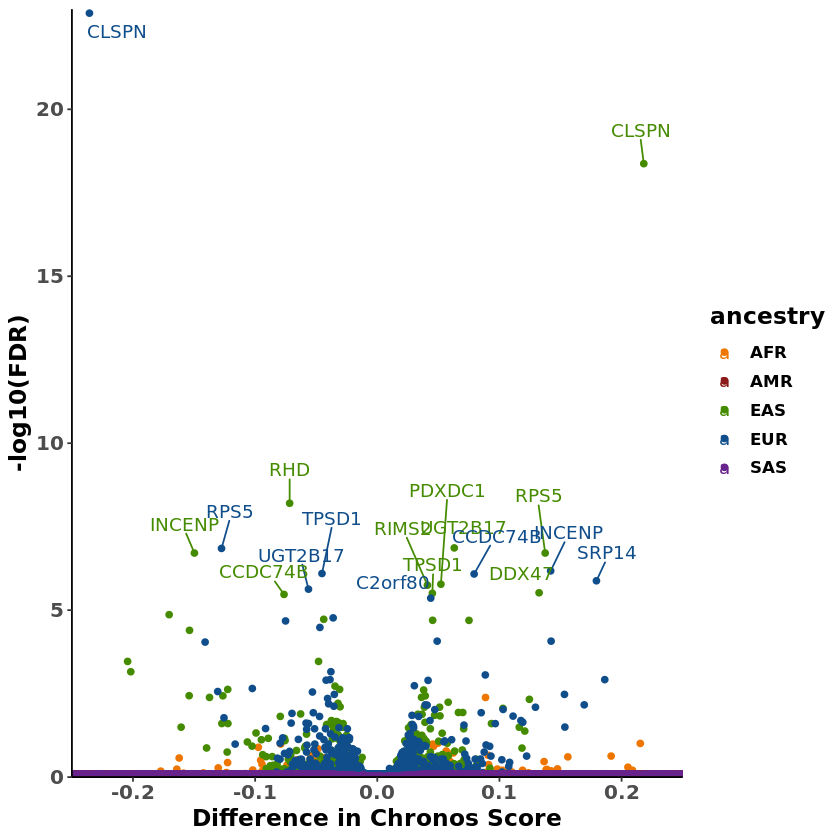

In [11]:
#Create the color vector
group.colors <- c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")

#Now finally plot the volcano plot
cat.volcano.df %>%
ggplot(aes(x = difference, y = -log10(FDR), color = ancestry)) +
geom_point(aes(x = difference, y = -log10(FDR), color = ancestry)) +

theme_bw() +
scale_colour_manual(values = group.colors) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

ylab("-log10(FDR)") +
xlab("Difference in Chronos Score") +
labs(fill='Ancestry Group') +
scale_y_continuous(expand = c(0,0), limits = c(0, 23)) +
scale_x_continuous(expand = c(0,0), limits = c(-0.25, 0.25)) +

geom_text_repel(
aes(label=ifelse(-log10(FDR) > 5, 
as.character(gene),'')), 
box.padding = 0.5,
nudge_y = 1,
segment.ncp = 3,
segment.angle = 20)

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("volcanoplot.pdf", width = 10, height = 10)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp volcanoplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Cool! We made the volcano plot. Now let's create a box and whisker plot for all of our favorite genes.

In [12]:
#First, assemble the dataset
genes.of.interest = c("CLSPN", "RHD", "INCENP", "RPS5", "RHD", "UGT2B17", "SRP14")

#Subset merged.dataset
goi.merged.dataset = merged.dataset %>% select(sample, EAS, EUR, all_of(genes.of.interest)) %>%
mutate(ancestry = ifelse(EAS >= 0.5, "EAS", ifelse(EUR > 0.5, "EUR", "Other"))) %>%
filter(ancestry %in% c("EUR", "EAS")) %>%
select(-c(EAS, EUR)) %>%
melt()

head(goi.merged.dataset)

Using sample, ancestry as id variables



,sample,ancestry,variable,value
,<chr>,<chr>,<fct>,<dbl>
1,ACH-000632,EUR,CLSPN,-0.7018285
2,ACH-000863,EUR,CLSPN,-0.5991165
3,ACH-000971,EUR,CLSPN,-0.8559159
4,ACH-000178,EUR,CLSPN,-0.5747957
5,ACH-000822,EUR,CLSPN,-1.2109635
6,ACH-000713,EUR,CLSPN,-1.1701173


Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”


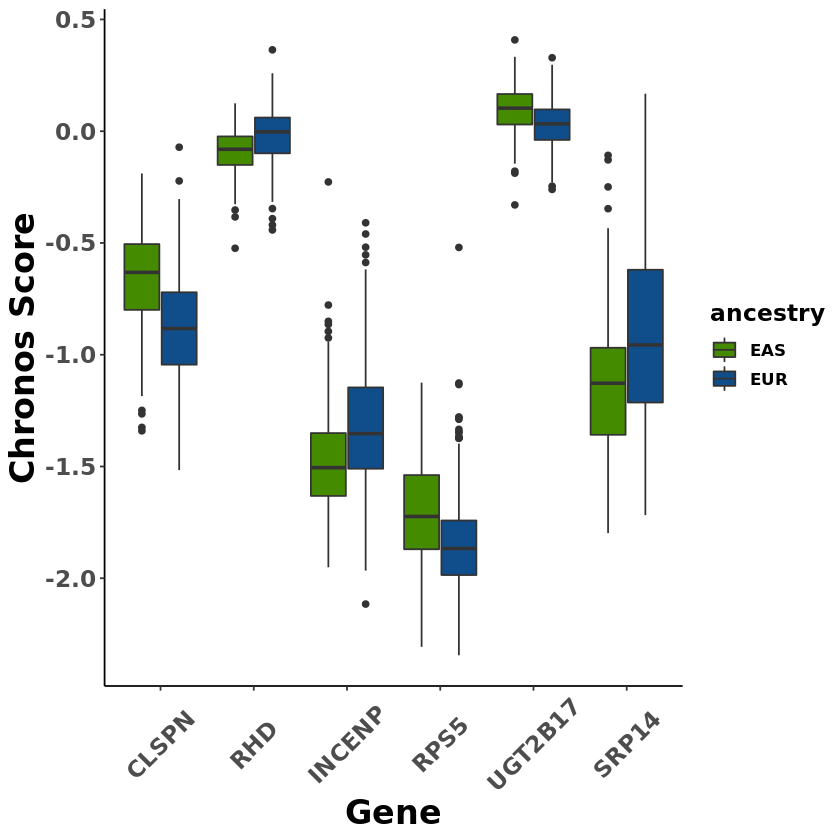

In [13]:
#Now make the plot!

#Now plot the data
set.seed(42)
group.colors <- c("EAS" = "chartreuse4", "EUR" = "dodgerblue4") #Make the color vector

goi.merged.dataset %>%
ggplot() +
geom_boxplot(position=position_dodge(0.8), aes(x = variable, y = value, fill = ancestry)) +
scale_fill_manual(values = group.colors) +

theme_bw() +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 20, face = "bold"),
axis.title.y = element_text(color = "black", size = 20, face = "bold")
) +

theme(
axis.text=element_text(size = 14, face = "bold"),
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5)
) +

xlab("Gene") +
ylab("Chronos Score") 

#Put the exported image into the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("ancestry_association_chronos.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp ancestry_association_chronos.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Now make a plot to show the sigificant genes per ancestry group.

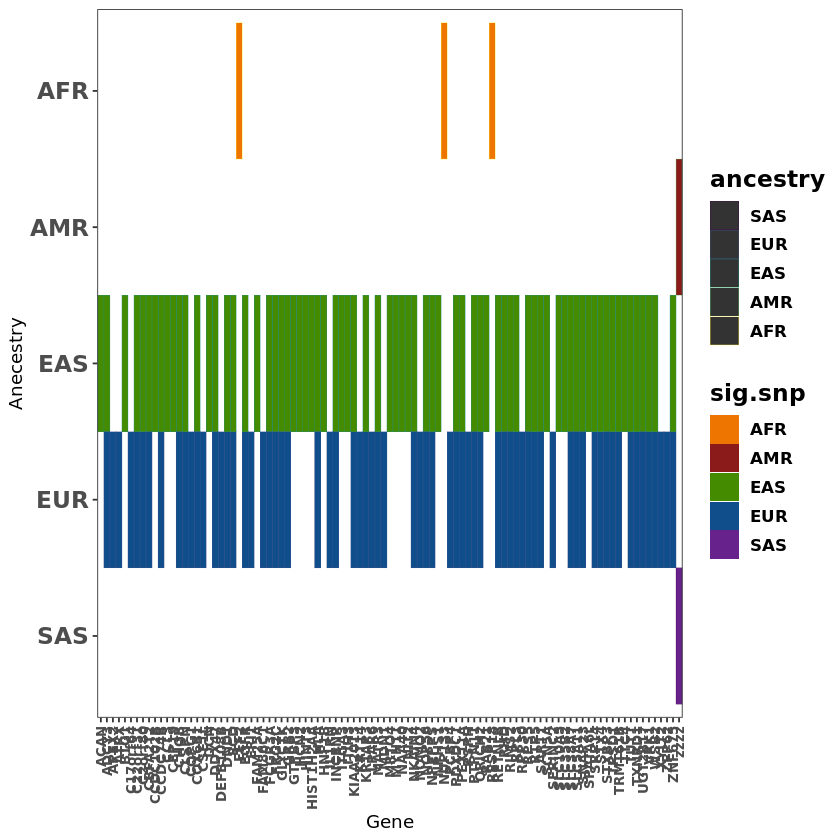

In [77]:
group.colors <- c(AFR = "darkorange2", AMR = "firebrick4", EAS = "chartreuse4", EUR = "dodgerblue4", SAS = "darkorchid4") #Make the color vector

#Massage a dataset so that we can make the heatmap.
cat.volcano.df %>%
filter(FDR < 0.05) %>%
arrange(FDR) %>%
mutate(gene = as.factor(gene)) %>%
add_row(gene = "zzzz", pval = 1, difference = 1, ancestry = "SAS", FDR = 1) %>%
add_row(gene = "zzzz", pval = 1, difference = 1, ancestry = "AMR", FDR = 1) %>%
mutate(sig.snp = "asdf") %>%
mutate(ancestry = factor(ancestry, ordered = TRUE, level = c("SAS", "EUR", "EAS", "AMR", "AFR"))) %>%



ggplot(aes(x = gene, y = as.factor(ancestry), fill = sig.snp, color = ancestry)) +
geom_tile(aes(fill = ancestry)) +
scale_fill_manual(values = group.colors) +


theme_bw() +


theme(
axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)
) +

theme(
#panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
#axis.line = element_line(color = "black")
) +

theme(
axis.text=element_text(size = 14, face = "bold"),
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

theme(
axis.text.x = element_text(size = 8),
) +


xlab("Gene") +
ylab("Anecestry") 



#Put the exported image into the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("ancestry.pval.heatmap.pdf", width = 10, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp ancestry.pval.heatmap.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

